In [56]:
from __future__ import print_function
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

def show_tensor_images(image_tensor, ax, num_images=25, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    ax.imshow(image_grid.permute(1, 2, 0).squeeze())
    ax.axis('off')

In [2]:
workers = 7
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 128
n_epochs = 200
z_dim = 64
hidden_dim = 128
im_dim = 28 * 28
lr = 0.00001
criterion = nn.BCEWithLogitsLoss()

In [4]:
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True, num_workers=workers)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            self.basic_block(z_dim, hidden_dim),
            self.basic_block(hidden_dim, hidden_dim * 2),
            self.basic_block(hidden_dim * 2, hidden_dim * 4),
            self.basic_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    
    def basic_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(True)
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            self.basic_block(im_dim, hidden_dim * 4),
            self.basic_block(hidden_dim * 4, hidden_dim * 2),
            self.basic_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    def basic_block(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, input):
        return self.main(input)

In [7]:
gen = Generator().to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
cur_step = 0
display_step = 500
mean_generator_loss = 0
mean_discriminator_loss = 0

G_losses = []
D_losses = []

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real_img, _ in tqdm(dataloader):
        cur_batch_size = len(real_img)
        
        real_img = real_img.view(cur_batch_size, -1).to(device)
        
        # Discriminator
        disc_opt.zero_grad()
        
        output = disc(real_img).view(-1)
        err_real = criterion(output,
                             torch.ones(cur_batch_size,
                                        device=device))
        
        
        noise = torch.randn([cur_batch_size, z_dim],
                            device=device)
        
        fake_img = gen(noise)
        
        output = disc(fake_img.detach()).view(-1)
        err_fake = criterion(output,
                             torch.zeros(cur_batch_size,
                                                 device=device))
        
        err_d = (err_real + err_fake) / 2.0
        
        err_d.backward()
        disc_opt.step()
        
        # Generator
        gen_opt.zero_grad()
        
        output = disc(fake_img).view(-1)
        
        err_g = criterion(output, torch.ones(cur_batch_size,
                                        device=device))
        
        err_g.backward()
        gen_opt.step()
        
        mean_discriminator_loss += err_d.item() / display_step
        mean_generator_loss += err_g.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print("Step: {0} - GLoss: {1} - DLoss: {2}".format(cur_step,
                                                                 round(mean_generator_loss, 4),
                                                                 round(mean_discriminator_loss, 4)))
            G_losses.append(mean_generator_loss)
            D_losses.append(mean_discriminator_loss)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            
        cur_step += 1

# Last step figures

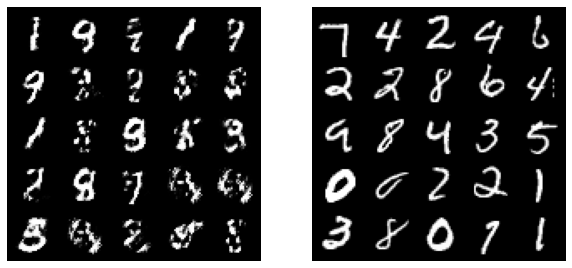

In [92]:
noise = torch.randn([real_img.size(0), z_dim],
                device=device)
fake = gen(noise)

fig, ax = plt.subplots(1,2,figsize=(10,6))

show_tensor_images(fake, ax[0])
show_tensor_images(real_img, ax[1])
plt.show()

# Loss

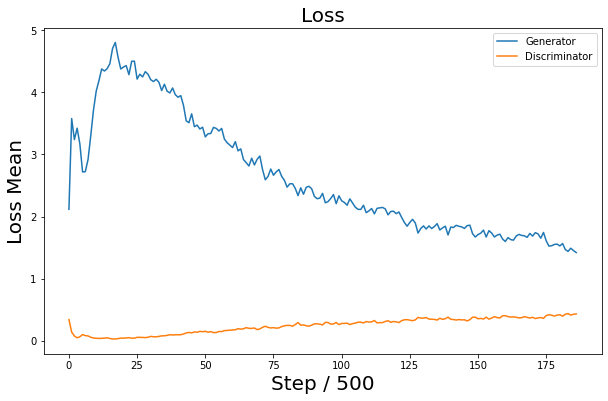

In [88]:
plt.figure(figsize=[10, 6])
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.title("Loss", fontsize=20)
plt.ylabel('Loss Mean', fontsize=20)
plt.xlabel('Step / {0}'.format(display_step), fontsize=20)
plt.legend()
plt.show()

# Save the model parameters

In [34]:
aux = !pwd
path = str(aux[0]) + '/basic_generator'
torch.save(gen.state_dict(), path)

aux = !pwd
path = str(aux[0]) + '/basic_discriminator'
torch.save(disc.state_dict(), path)

In [93]:
exit()